<h1>
<center>CFRM 421/521, Spring 2022</center>
</h1>

<h1>
<center>Wendy Jiang</center>
</h1>

<h1>
<center>Homework 1</center>
</h1>

* **Due: Monday, April 18, 2022, 11:59 PM**


* Total marks: 46


* Late submissions are allowed, but a 20% penalty per day applies. Your last submission is considered for calculating the penalty.


*  Use this Jupyter notebook as a template for your solutions. **Your solution must be submitted as one Jupyter notebook.** The notebook must be already run, that is, make sure that you have run all your code, save the notebook, and then when you reopen the notebook, checked that all output appears as expected. You are allowed to use code from the textbook, textbook website, or lecture notes.

# 1. Preprocessing housing data [7 marks]

Hint: Reading Chapter 2 of the textbook and the accompanying [Jupyter notebook](https://github.com/ageron/handson-ml2/blob/master/02_end_to_end_machine_learning_project.ipynb) on the textbook website may help with this question.

Consider the California housing data from Chapter 2 of the textbook. The following code fetches the data.

In [566]:
import os
import tarfile
from six.moves import urllib
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit

HOUSING_PATH = os.path.join("datasets", "housing")

def fetch_housing_data(housing_url, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

HOUSING_URL = ("https://raw.githubusercontent.com/ageron/"+
               "handson-ml2/master/datasets/housing/housing.tgz")
fetch_housing_data(HOUSING_URL)
data = load_housing_data()

Next, we create stratified test and training sets based on different income categories.

In [567]:
data["income_cat"] = np.ceil(data["median_income"] / 1.5)
data["income_cat"].where(data["income_cat"] < 5, 5.0, inplace=True)

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(data, data["income_cat"]):
    strat_train_set = data.loc[train_index]
    strat_test_set = data.loc[test_index]
    
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

Let us separate the features (`X_raw`) and the response variable (`y`).

In [568]:
X_raw = strat_train_set.drop("median_house_value", axis=1)
y = strat_train_set["median_house_value"].copy()

## (a) Handling missing values [1 mark]

Let us find out if there are any missing values in our features. As the code below indicates, out of 16512 observations, 158 have missing values. Further inspection shows that `total_bedrooms` has missing values (only a few missing values are shown below).

In [569]:
X_raw.shape

(16512, 9)

In [570]:
X_raw[X_raw.isnull().any(axis=1)].shape

(158, 9)

In [571]:
X_raw[X_raw.isnull().any(axis=1)].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,NaN,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,NaN,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,NaN,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,NaN,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,NaN,3468.0,1405.0,3.1662,<1H OCEAN


**Task:** Read the subsection "Data Cleaning" in Chapter 2 of the textbook. Use the `sklearn.impute.SimpleImputer` class to fill the missing values in the numerical features (everything except `ocean_proximity`) with the median of the corresponding feature.


**[Add your solution here]**

In [572]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
housing_num = X_raw.drop("ocean_proximity", axis = 1)
imputer.fit(housing_num)

# use this "trained" imputer to transfrom the training set by replaceing missing values with the learned medians
X_num = imputer.transform(housing_num)
X_num = pd.DataFrame(X_num,columns=housing_num.columns)
X_num

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042
1,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214
2,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621
3,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839
4,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347
...,...,...,...,...,...,...,...,...
16507,-118.13,34.20,46.0,1271.0,236.0,573.0,210.0,4.9312
16508,-117.56,33.88,40.0,1196.0,294.0,1052.0,258.0,2.0682
16509,-116.40,34.09,9.0,4855.0,872.0,2098.0,765.0,3.2723
16510,-118.01,33.82,31.0,1960.0,380.0,1356.0,356.0,4.0625


## (b) Handling categorical features  [2 marks]
ML algorithms generally work with numerical values. So, we need to convert categorical features to numerical values. One way is to simply map each category to an integer. Another alternative is to use **one-hot encoding**.

**Task:** Read subsection "Handling Text and Categorical Attributes" in Chapter 2 of the textbook. Then use the `sklearn.preprocessing.OrdinalEncoder` class and the `sklearn.preprocessing.OneHotEncoder` class to transform the `ocean_proximity` feature to integers and one-hot vectors. Explain why it is more appropriate to use one-hot encoding.

**[Add your solution here]**

In [573]:
# Convert the categories from text to numbers
# use sklearn.preprocessing.OrdinalEncoder class
housing_cat = X_raw[["ocean_proximity"]]
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
print(housing_cat_encoded[:10])
ordinal_encoder.categories_   # get the list of categories

[[0.]
 [0.]
 [4.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]]


[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [574]:
# use sklearn.preprocessing.OneHotEncoder class
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot
print(housing_cat_1hot.toarray()) #convert the 2-D array to a NumPy array
cat_encoder.categories_   # get the list of categories

[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 ...
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]]


[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

Since the representation of Ordinal Encoding is that the ML algorithms will assume that two nearby values are more similar than two distant values. This is not fine for the `ocean_proximity` column. However, the one-hot encoding can fit this issue. Therefore, one-hot encoding is more appropriate.

## (c) Feature scaling [2 marks]

Many ML algorithms do not perform well if the features have different scales (some very small, and others very large). In such scenarios, one should transform the features so that they have similar range of values. There are two common ways to achieve this. In **min-max** scaling, we subtract the feature from its minimum value and then divide by its range (i.e. maximum value minus minimum value) so that the scaled values are between 0 and 1. In **standardization**, we subtract the values from the average and divide by the standard deviation, so that the transformed values has mean 0 and variance 1.

**Task:** Read the subsection "Feature Scaling" in Chapter 2 of the textbook. Use the `sklearn.preprocessing.MinMaxScaler` class and `sklearn.preprocessing.StandardScaler` class to scale the numerical features using min-max scaling and standardization.


In [575]:
data = X_raw.loc[:, X_raw.columns != 'ocean_proximity']

**[Add your solution here]**

In [576]:
# min-max scaling
from sklearn.preprocessing import MinMaxScaler
scaler_m = MinMaxScaler()
scaled_m = scaler_m.fit_transform(data)
print(scaled_m)

[[0.24501992 0.50478215 0.7254902  ... 0.01981558 0.06292009 0.15201859]
 [0.24103586 0.47927736 0.25490196 ... 0.00849239 0.02072442 0.40837368]
 [0.71215139 0.02444208 0.58823529 ... 0.02614984 0.08588499 0.1629081 ]
 ...
 [0.79183267 0.16471838 0.15686275 ... 0.05871801 0.14245706 0.19119736]
 [0.6314741  0.1360255  0.58823529 ... 0.03792147 0.0660941  0.24569316]
 [0.18924303 0.55579171 1.         ... 0.03548306 0.11893204 0.21207294]]


In [577]:
# standardization
from sklearn.preprocessing import StandardScaler
scaler_s = StandardScaler()
scaled_s = scaler_s.fit_transform(data)
print(scaled_s)

[[-1.15604281  0.77194962  0.74333089 ... -0.63621141 -0.42069842
  -0.61493744]
 [-1.17602483  0.6596948  -1.1653172  ... -0.99833135 -1.02222705
   1.33645936]
 [ 1.18684903 -1.34218285  0.18664186 ... -0.43363936 -0.0933178
  -0.5320456 ]
 ...
 [ 1.58648943 -0.72478134 -1.56295222 ...  0.60790363  0.71315642
  -0.3167053 ]
 [ 0.78221312 -0.85106801  0.18664186 ... -0.05717804 -0.37545069
   0.09812139]
 [-1.43579109  0.99645926  1.85670895 ... -0.13515931  0.3777909
  -0.15779865]]


## (d) Transformation pipelines [2 marks]

Usually, we have to perform several steps before the data is ready to be fed to an ML algorithm. Scikit-Learn's `Pipeline` class provides a systematic way of "packaging" such a sequence of transformations.

**Task:** Read the subsection "Transformation Pipelines" in Chapter 2 of the textbook. Then, create one pipeline that applies the transformations on part (a), (b) (use one-hot encoding), and (c) (use standardization) to the "raw" features `X_raw`. Call your transformed data `X`.

**[Add your solution here]**

In [578]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
num_pipeline = Pipeline([
            ('imputer', SimpleImputer(strategy="median")),
            ('std_scaler', StandardScaler())])

from sklearn.compose import ColumnTransformer
num_attribs = list(X_num)
cat_attribs = ["ocean_proximity"]
full_pipeline = ColumnTransformer([
             ("num", num_pipeline, num_attribs),
             ("cat", OneHotEncoder(), cat_attribs)])
X = full_pipeline.fit_transform(X_raw)

In [579]:
print(X)

[[-1.15604281  0.77194962  0.74333089 ...  0.          0.
   0.        ]
 [-1.17602483  0.6596948  -1.1653172  ...  0.          0.
   0.        ]
 [ 1.18684903 -1.34218285  0.18664186 ...  0.          0.
   1.        ]
 ...
 [ 1.58648943 -0.72478134 -1.56295222 ...  0.          0.
   0.        ]
 [ 0.78221312 -0.85106801  0.18664186 ...  0.          0.
   0.        ]
 [-1.43579109  0.99645926  1.85670895 ...  0.          1.
   0.        ]]


# 2. Fine-tuning models [16 marks]

Hint: Reading Chapter 2 of the textbook and the accompanying [Jupyter notebook](https://github.com/ageron/handson-ml2/blob/master/02_end_to_end_machine_learning_project.ipynb) on the textbook website may help with this question.

## (a) Linear regression [2 marks]

**Task:** Use the `sklearn.linear_model.LinearRegression` class to fit a linear regression to the training set in Question 1. Use the processed features `X` that you obtained in 1(d) as predictors and `y` (the median house values) as the response. Return fitted values of the response for the first 10 observations of the training set.

**[Add your solution here]**

In [580]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, y)

LinearRegression()

In [581]:
X_train = X[:10,]
y_pred = lin_reg.predict(X_train)
print(y_pred)

[211574.39523833 321345.10513719 210947.519838    61921.01197837
 192362.32961119 154821.86099031 426129.59146334 229666.3616775
 141483.54356476  12084.19502002]


## (b) RMSE and MAE  [2 marks]

We can measure the out-of-sample performance with root mean square error (RMSE) and mean absolute error (MAE). 

**Task:** Use `mean_squared_error` and `mean_absolute_error` functions from `sklearn.metrics` to calculate the in-sample RMSE and MAE of the linear regression that you fit in part (a).

**[Add your solution here]**

In [582]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
lin_mse = mean_squared_error(y[:10,],y_pred)
lin_rmse = np.sqrt(lin_mse)
lin_mae = mean_absolute_error(y[:10,],y_pred)
print(lin_rmse)
print(lin_mae)

162699.58854606905
91074.66815788865


## (c) Cross validation  [3 marks]

In part (b), we evaluated the in-sample performance of the linear regression model. To obtain out-of-sample performance, we use K-fold cross validation.

**Task:** Use the `cross_val_score` function from `sklearn.model_selection` to perform 10-fold  cross validation on the linear regression from part (a) and return the values of **RMSE**. Return the 10 RMSE scores as well as their mean.

**[Add your solution here]**

In [583]:
from sklearn.model_selection import cross_val_score
lin_scores = cross_val_score(lin_reg, X, y,scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
print(lin_rmse_scores)

[67450.42057782 67329.50264436 68361.84864912 74639.88837894
 68314.56738182 71628.61410355 65361.14176205 68571.62738037
 72476.18028894 68098.06828865]


## (d) Alternatives to linear regression [3 marks]
Let us consider fitting two alternative models, namely, **decision trees** and **random forests**. These models will be discussed in future lectures. The following code fits a decision tree and obtains the fitted response for the first 10 observations.

In [584]:
from sklearn.tree import DecisionTreeRegressor
dt_reg = DecisionTreeRegressor(random_state=42)
dt_reg.fit(X,y)

DecisionTreeRegressor(random_state=42)

In [585]:
dt_reg.predict(X[:10,])

array([286600., 340600., 196900.,  46300., 254500., 127900., 500001.,
       140200.,  95000., 500001.])

The following code does the same for the random forest model.

In [586]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor(bootstrap=True, n_estimators=100, max_depth=5, random_state=42)
rf_reg.fit(X, y)

RandomForestRegressor(max_depth=5, random_state=42)

In [587]:
rf_reg.predict(X[:10,])

array([197897.38186239, 312857.05480804, 170838.26502119,  78919.95143337,
       213978.99963998, 127669.93984961, 454196.74104933, 204609.56439446,
       138451.98867262, 153166.14428368])

**Task:** Find the in-sample performance of the decision tree and the random forest using RMSE on the training set. Also, find the out-of-sample performance by 10-fold cross validation as you did in part (c). Which of the 3 models has the best in-sample performance? Which has the best out-of-sample performance?

**[Add your solution here]**

In [588]:
# in sample performance -- RMSE on training set
dt_prediction = dt_reg.predict(X[:10,])
tree_mse = mean_squared_error(y[:10,], dt_prediction)
tree_rmse = np.sqrt(tree_mse)
print(tree_mse)

rf_prediction = rf_reg.predict(X[:10,])
rf_mse = mean_squared_error(y[:10,], rf_prediction)
rf_rmse = np.sqrt(rf_mse)
print(rf_rmse)

0.0
118512.53930058732


In [589]:
# out of sample performance
from sklearn.model_selection import cross_val_score
dt_reg_rmse = -cross_val_score(dt_reg, X, y, cv=10, scoring="neg_root_mean_squared_error")
print(dt_reg_rmse)

rf_reg_rmse = -cross_val_score(rf_reg, X, y, cv=10, scoring="neg_root_mean_squared_error")
print(rf_reg_rmse)

[66757.2013883  66708.05413959 71135.77592971 69317.58307062
 68729.37098167 75649.34082791 67043.83260349 70251.84122452
 69273.49135944 69161.37598811]
[65700.45624157 65412.32803475 67106.0935323  68745.76431365
 68377.99796777 72240.18920168 63778.47273911 67392.56263794
 71018.43990131 69008.50914107]


Compared above three models, the ramdom forest looks better.

## (e) Choosing optimal values of hyperparameters using cross validation [4 marks]

Most ML algorithms have **hyperparameters**. These hyperparameters control the learning process and should not be confused with the model parameters (which are the unknown values that are being estimated). For example, the random forest algorithm has 3 hyperparameters, namely `bootstrap`, `n_estimators`, and `max_depth`. To fine-tune a model, we should find good values of the hyperparameters based on out-of-sample performance.

**Task:** Read the subsections "Grid Search" and "Randomized Search" in Chapter 2 of the textbook. Consider the random forest model with the argument `random_state=42`. Use the `sklearn.model_selection.GridSearchCV` class to choose the best hyperparameter values for `bootstrap` over the values `True`, `False`; `n_estimators` over the values 50, 100, 200; and `max_depth` over the values 5, 20, 40. Use 4-fold cross-validation with RMSE when searching for the hyperparameters.

Next, use the `sklearn.model_selection.RandomizedSearchCV` class to perform a randomized search over the same ranges with 18 parameter settings sampled, that is `bootstrap` is `True` or `False` with equal probability, `n_estimators` is a uniform random integer between 50 and 200, `max_depth` is a uniform random integer between 5 and 40. `RandomizedSearchCV` must include the argument `random_state=42`.

In both functions, you may use the argument `n_jobs=-1` to use all avaliable processor cores to speed up the calculation. Based on all of your results, what are the best hyperparameter values?

**[Add your solution here]**

In [590]:
from sklearn.model_selection import GridSearchCV
param_grid = [{'n_estimators' : [50,100,200],
              'max_depth' : [5,20,40]},
             {'bootstrap': [True, False],
              'n_estimators' : [50,100,200],
              'max_depth' : [5,20,40]}]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv = 4, 
                           scoring = 'neg_mean_squared_error',
                          return_train_score = True, n_jobs=-1)

grid_search.fit(X,y)

/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=4, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid=[{'max_depth': [5, 20, 40],
                          'n_estimators': [50, 100, 200]},
                         {'bootstrap': [True, False], 'max_depth': [5, 20, 40],
                          'n_estimators': [50, 100, 200]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [591]:
grid_search.best_params_

{'bootstrap': True, 'max_depth': 40, 'n_estimators': 200}

In [592]:
from scipy.stats import uniform

from sklearn.model_selection import RandomizedSearchCV

param_grid = [{'n_estimators' : [50,100,200],
              'max_depth' : [5,20,40]},
             {'bootstrap' : [False],
              'n_estimators' : uniform(50,200),
              'max_depth' : uniform(5,40)}]

forest_reg = RandomForestRegressor()

grid_search_ramdom = RandomizedSearchCV(forest_reg, param_grid, cv = 4, 
                           scoring = 'neg_mean_squared_error', n_iter=18,
                          return_train_score = True, random_state=42, n_jobs=-1)

grid_search_ramdom.fit(X,y)

/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


RandomizedSearchCV(cv=4, estimator=RandomForestRegressor(), n_iter=18,
                   n_jobs=-1,
                   param_distributions=[{'max_depth': [5, 20, 40],
                                         'n_estimators': [50, 100, 200]},
                                        {'bootstrap': [False],
                                         'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fb8b814ad60>,
                                         'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fb8b813e1c0>}],
                   random_state=42, return_train_score=True,
                   scoring='neg_mean_squared_error')

In [593]:
grid_search.best_params_

{'bootstrap': True, 'max_depth': 40, 'n_estimators': 200}

## (f) Evaluating your final model using the test set [2 marks]

The last step of a ML project is to evaluate your (fine-tuned) model using the test set. The goal of this step is to estimate the out-of-sample performance of your trained model on new data. **Be careful not to train your model using the test set.** Do not use `.fit()` or `.fit_tranform()` of your estimators or pipelines. Also, **do not fine tune your hyperparameters after finding out the performance of a model on the test set as that would be data snooping.**

**Task:** Using the test set, find the RMSE of your best model in part (e).

**[Add your solution here]**

In [594]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"],cvres["params"]): print(np.sqrt(-mean_score),params)

67818.58001791187 {'max_depth': 5, 'n_estimators': 50}
67774.29844514364 {'max_depth': 5, 'n_estimators': 100}
67682.14324679808 {'max_depth': 5, 'n_estimators': 200}
50343.285814728275 {'max_depth': 20, 'n_estimators': 50}
50210.36951393731 {'max_depth': 20, 'n_estimators': 100}
50027.729730223844 {'max_depth': 20, 'n_estimators': 200}
50449.842262858365 {'max_depth': 40, 'n_estimators': 50}
50053.21570741115 {'max_depth': 40, 'n_estimators': 100}
50004.31842092859 {'max_depth': 40, 'n_estimators': 200}
67840.30812779778 {'bootstrap': True, 'max_depth': 5, 'n_estimators': 50}
67735.54893328281 {'bootstrap': True, 'max_depth': 5, 'n_estimators': 100}
67720.03390021069 {'bootstrap': True, 'max_depth': 5, 'n_estimators': 200}
50472.25676967705 {'bootstrap': True, 'max_depth': 20, 'n_estimators': 50}
50292.09684318014 {'bootstrap': True, 'max_depth': 20, 'n_estimators': 100}
50001.808524821165 {'bootstrap': True, 'max_depth': 20, 'n_estimators': 200}
50532.505616957475 {'bootstrap': True,

We obtain the best solution is max_depth = 40 and n_estimators = 200. The RMSE score for this combination is 49940, which is slightly better. 

# 3. Regularizing linear regression [6 marks]

Consider the housing data set from Questions 1 and 2.

## (a) Polynomial regression and regularizing [2 marks]

Fit a model that adds degree 3 polynomial terms to the linear regression in 2(a). Next, regularize the model using ridge regression with parameter $\alpha=1$.

**[Add your solution here]**

In [597]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=3, include_bias=False)
X_poly = poly_features.fit_transform(X)

lin_reg_poly = LinearRegression()
lin_reg_poly.fit(X_poly, y)

LinearRegression()

In [598]:
print(X_poly)

[[-1.15604281  0.77194962  0.74333089 ...  0.          0.
   0.        ]
 [-1.17602483  0.6596948  -1.1653172  ...  0.          0.
   0.        ]
 [ 1.18684903 -1.34218285  0.18664186 ...  0.          0.
   1.        ]
 ...
 [ 1.58648943 -0.72478134 -1.56295222 ...  0.          0.
   0.        ]
 [ 0.78221312 -0.85106801  0.18664186 ...  0.          0.
   0.        ]
 [-1.43579109  0.99645926  1.85670895 ...  0.          0.
   0.        ]]


In [602]:
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=1, solver="cholesky", random_state=42)
ridge_reg.fit(X_poly, y)

Ridge(alpha=1, random_state=42, solver='cholesky')

## (b) Learning curves [4 marks]

Obtain learning curves for the linear regression model that you fitted in 2(a), the polynomial regression model in 3(a), and the ridge regression model in 3(a). Hence, comment on whether the curves indicate the models are underfitting, overfitting or neither. When plotting the learning curve, use the function `train_test_split` with the argument `random_state=10` to create a validation set from a random 20% split of the test set. Instead of adding 1 instance at a time in the learning curve, add 1000 instances at a time.

**[Add your solution here]**

In [603]:
import matplotlib as mlp
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)
    train_errors, val_errors = [], []
    for m in range(1000, len(X_train),1000):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))
        
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)   
    plt.xlabel("Training set size", fontsize=14) 
    plt.ylabel("RMSE", fontsize=14)  

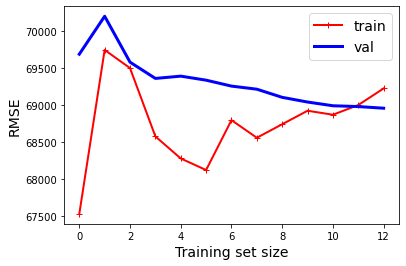

In [596]:
plot_learning_curves(lin_reg, X, y) 
plt.show()

The curves indicate the models are underfitting

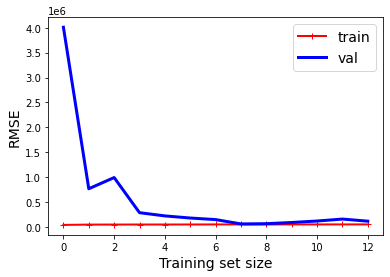

In [604]:
plot_learning_curves(lin_reg_poly, X_poly, y)

The curves indicate the models are underfitting

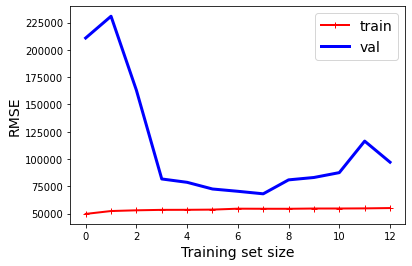

In [605]:
plot_learning_curves(ridge_reg, X_poly, y)

The curves indicate the models are overfitting

# 4. Default dataset [17 marks]


In this question you will work with the Default dataset, which is a simulated dataset of credit card default for 10000 customers. Download the data as a csv file from [Canvas](https://canvas.uw.edu/files/90503805/download?download_frd=1). The data was originally obtained from the R library ISLR2, and you can read the documentation for the dataset [here](https://cran.rstudio.com/web/packages/ISLR2/ISLR2.pdf).

You want to predict credit card defaults. The target for this classification problem is `default` and all other variables are the features. 

## (a) [2 marks]
Load the dataset. If it is stored in a file named `Default.csv` in your working directory, this can be done with the code below. Then split the data into a training and a test set, using 20% of the data for the test set. When doing the splitting, use the random seed 42.

In [647]:
import os
data = pd.read_csv("Default.csv")

In [648]:
data.head()

,default,student,balance,income
0,No,No,729.526495,44361.625074
1,No,Yes,817.180407,12106.134700
2,No,No,1073.549164,31767.138947
3,No,No,529.250605,35704.493935
4,No,No,785.655883,38463.495879


**[Add your solution here]**

In [649]:
from sklearn.preprocessing import OrdinalEncoder
X_default = data.drop("default", axis=1)
y_default = data[["default"]]
ordinal_encoder = OrdinalEncoder()
y_default = ordinal_encoder.fit_transform(y_default)
X_train, X_test, y_train, y_test = train_test_split(X_default, y_default, test_size=0.2, random_state=42)

## (b) [3 marks]

Design a pipeline for preprocessing that applies one hot encoding to the categorical features and a standard scaler to the numerical features.

**[Add your solution here]**

In [650]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

full_pipeline = ColumnTransformer([
        ("num", StandardScaler(), ["balance", "income"]),
        ("cat", OneHotEncoder(), ["student"]),
    ])

In [651]:
X_train_full = full_pipeline.fit_transform(X_train)
X_test = full_pipeline.fit_transform(X_test)
y_train_full = y_train.ravel()
y_test = y_test.ravel()

## (c) [4 marks]
Train a logistic regression classifier and a `SGDClassifier`, and then using 10-fold cross-validation plot the ROC curve of the classifiers and compute their ROC AUC.

**[Add your solution here]**

In [652]:
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
#Train a logistic regression classifier
log_clf = LogisticRegression()
log_clf.fit(X_train_full,y_train_full)

#Train SGDClassifier
sgd_clf = SGDClassifier()
sgd_clf.fit(X_train_full,y_train_full)

SGDClassifier()

In [653]:
from sklearn.model_selection import cross_val_predict
y_log_score = cross_val_predict(log_clf,X_train_full,y_train_full,cv=10,method="decision_function")

y_sgd_score = cross_val_predict(sgd_clf,X_train_full,y_train_full,cv=10,method="decision_function")

from sklearn.metrics import roc_curve
fpr_log,tpr_log,thresholds_log = roc_curve(y_train_full,y_log_score)
fpr_sgd,tpr_sgd,thresholds_sgd = roc_curve(y_train_full,y_sgd_score)

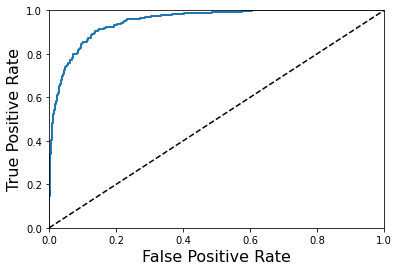

In [654]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    
plot_roc_curve(fpr_log,tpr_log)
plt.show()

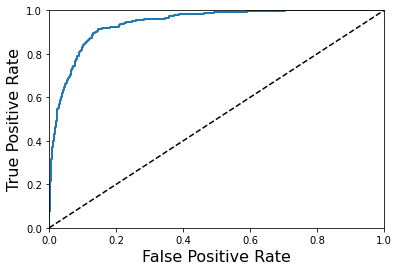

In [655]:
plot_roc_curve(fpr_sgd,tpr_sgd)
plt.show()

In [656]:
#compute AUC
from sklearn.metrics import roc_auc_score

auc_log = roc_auc_score(y_train_full, y_log_score)
auc_sgd = roc_auc_score(y_train_full, y_sgd_score)

print("ROG AUC of Logistic Regression:", auc_log)
print("ROG AUC of SGD Classifier:", auc_sgd)

ROG AUC of Logistic Regression: 0.9501670662154117
ROG AUC of SGD Classifier: 0.9407531885556704


The ROC AUC of the logistic regression classifier accuracy is 0.9525 and of the SGDClassifier accuracy is 0.9431

## (d) [5 marks]

For the classifiers in part (c), plot on the same axes the precision as a function of the threshold and the recall as a function of the threshold. Now suppose you want to achieve a recall of 80%. Consider 4 models:
 1.  The logistic regression classifier in (c),
 2. `SGDClassifier` in (c),
 3. A logistic regression with the argument `class_weight="balanced"`,
 4. `SGDClassifier` with the argument `class_weight="balanced"`.
 
For each of the 4 models, determine the threshold to achieve an 80% recall based on 10-fold cross-validation. Then determine the corresponding precisions. Which model has the best precision?

**[Add your solution here]**

In [657]:
#1
from sklearn.metrics import precision_recall_curve
precisions_log, recalls_log, thresholds_log = precision_recall_curve(y_train_full, y_log_score)

In [658]:
#2
precisions_sgd, recalls_sgd, thresholds_sgd = precision_recall_curve(y_train_full, y_sgd_score)

In [661]:
#3
log_clf_new = LogisticRegression(class_weight="balanced")
log_clf_new.fit(X_train_full,y_train_full)
y_log_score_new = cross_val_predict(log_clf_new,X_train_full,y_train_full,cv=10,method="decision_function")
precisions_log_new, recalls_log_new, thresholds_log_new = precision_recall_curve(y_train_full, y_log_score_new)

In [662]:
#4
sgd_clf_new = SGDClassifier(class_weight="balanced")
sgd_clf_new.fit(X_train_full,y_train_full)
y_sgd_score_new = cross_val_predict(sgd_clf_new,X_train_full,y_train_full,cv=10,method="decision_function")
precisions_sgd_new, recalls_sgd_new, thresholds_sgd_new = precision_recall_curve(y_train_full, y_sgd_score_new)

In [663]:
threshold_80_recalls1 = thresholds_log[np.argmax(recalls_log <= 0.80)]
threshold_80_recalls2 = thresholds_sgd[np.argmax(recalls_sgd <= 0.80)]
threshold_80_recalls3 = thresholds_log_new[np.argmax(recalls_log_new <= 0.80)]
threshold_80_recalls4 = thresholds_sgd_new[np.argmax(recalls_sgd_new <= 0.80)]
print(threshold_80_recalls1)
print(threshold_80_recalls2)
print(threshold_80_recalls3)
print(threshold_80_recalls4)

-2.6988895920373728
-1.8383953952477823
0.6601736819508885
1.114796105906393


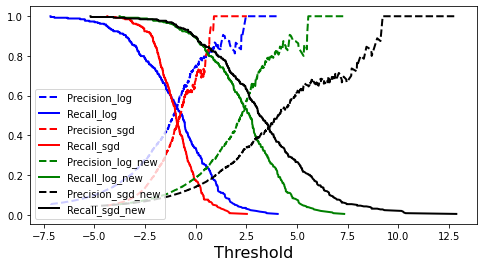

In [668]:
plt.figure(figsize=(8, 4))
plt.plot(thresholds_log, precisions_log[:-1], "b--", label="Precision_log", linewidth=2)
plt.plot(thresholds_log, recalls_log[:-1], "b-", label="Recall_log", linewidth=2)
plt.plot(thresholds_sgd, precisions_sgd[:-1], "r--", label="Precision_sgd", linewidth=2)
plt.plot(thresholds_sgd, recalls_sgd[:-1], "r-", label="Recall_sgd", linewidth=2)
plt.plot(thresholds_log_new, precisions_log_new[:-1], "g--", label="Precision_log_new", linewidth=2)
plt.plot(thresholds_log_new, recalls_log_new[:-1], "g-", label="Recall_log_new", linewidth=2)
plt.plot(thresholds_sgd_new, precisions_sgd_new[:-1], "k--", label="Precision_sgd_new", linewidth=2)
plt.plot(thresholds_sgd_new, recalls_sgd_new[:-1], "k-", label="Recall_sgd_new", linewidth=2)
plt.xlabel("Threshold", fontsize=16)
plt.legend(loc="lower left")
plt.show()

In [669]:
from sklearn.metrics import precision_score
y_train_pred_80_1 = (y_log_score >= threshold_80_recalls1)
precision_score(y_train_full,y_train_pred_80_1)

0.2505938242280285

In [670]:
y_train_pred_80_2 = (y_sgd_score >= threshold_80_recalls2)
precision_score(y_train_full,y_train_pred_80_2)

0.23314917127071824

In [671]:
y_train_pred_80_3 = (y_log_score_new >= threshold_80_recalls3)
precision_score(y_train_full,y_train_pred_80_3)

0.24794359576968272

In [672]:
y_train_pred_80_4 = (y_sgd_score_new >= threshold_80_recalls4)
precision_score(y_train_full,y_train_pred_80_4)

0.20747295968534907

Since we calculate the prediction precision, the logistic regression classifier in (c), has better performance.

## (e) [3 marks]

Fit the best classifier in (d) to the whole training data, and use it to predict on the test set. What is its accuracy, precision, recall, ROC curve and ROC AUC over the test set?

**[Add your solution here]**

In [674]:
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
#Train a logistic regression classifier
log_clf = LogisticRegression()
log_clf.fit(X_train_full,y_train_full)
# on test set
# accuracy
y_pred = log_clf.predict(X_test)
n_correct = sum(y_pred==y_test)  # FALSE is 0, TRUE is 1
accuracy = 100*n_correct / len(y_pred)
print("{} correct predictions out of {} ({:.2f}%)"
      
      .format(n_correct,len(y_pred),accuracy))
from sklearn.model_selection import cross_val_predict
y_log_score = cross_val_predict(log_clf,X_test,y_test,cv=10,method="decision_function")

from sklearn.metrics import precision_recall_curve
precisions_log, recalls_log, thresholds_log = precision_recall_curve(y_test, y_log_score)
# recall
threshold_80_recalls = thresholds_log[np.argmax(recalls_log <= 0.80)]
print(threshold_80_recalls)
# precision
from sklearn.metrics import precision_score
y_train_pred_80 = (y_log_score >= threshold_80_recalls)
precision_score(y_test,y_train_pred_80)

1939 correct predictions out of 2000 (96.95%)
-2.580240399077701


0.24444444444444444

The accuracy over the test set is 96.95%. The recall of the test set is -2.58 and precision is 0.244.

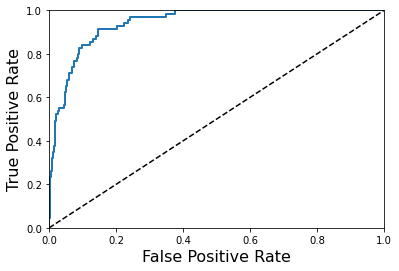

In [675]:
#ROC curve
fpr_log,tpr_log,thresholds_log = roc_curve(y_test,y_log_score)

plot_roc_curve(fpr_log,tpr_log)
plt.show()

In [676]:
# ROC AUC
auc_log = roc_auc_score(y_test, y_log_score)
print(auc_log)

0.9425468518977176


ROC AUC over the test set is 0.9425